# Load water level data from DMI

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

In [3]:
from tsod.detectors import CombinedDetector, RangeDetector, DiffRangeDetector, RollingStandardDeviationDetector
from tsod.hampel import HampelDetector

In [4]:
file_path = os.path.join("..", "tests", "data", "Ballen_20150218-20201222.csv")
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

In [5]:
sampling_period = df.index.to_series().diff().median()  # detect sampling period
equidistant_times = pd.date_range(df.index.min(), df.index.max(), freq=sampling_period)
data = df.water_level.reindex(equidistant_times)  # add equidistant timestamps with no measurements

<AxesSubplot:>

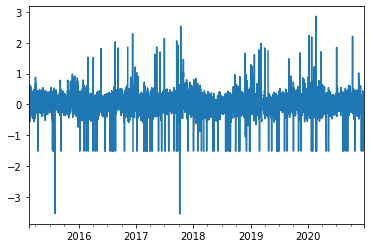

In [6]:
data.plot()

# Detect anomalies outside manually set range

In [7]:
range_anomalies = RangeDetector(-1, 1.3).detect(data)

<AxesSubplot:title={'center':'Anomalies detected: 1254'}>

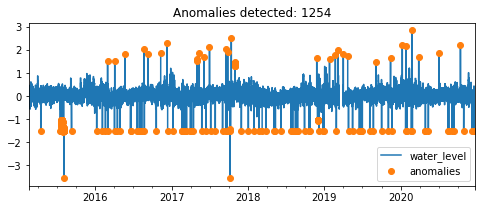

In [8]:
detected = data.to_frame()
detected["anomalies"] = data[range_anomalies.values]
detected.plot(style=['-', 'o'], figsize=(8,3), title=f"Anomalies detected: {range_anomalies.sum()}")

In [9]:
data_clean = data.copy()
data_clean[range_anomalies.values] = np.nan

# Detect anomalies outside automatically set range

In [10]:
N = 1000
normal_data, test_data = data[:N], data[N:]

In [11]:
anomaly_detector = CombinedDetector([RangeDetector(), DiffRangeDetector()])
anomaly_detector.fit(normal_data)
detected_anomalies = anomaly_detector.detect(test_data)

In [12]:
detected_anomalies.head()

2015-02-25 11:10:00    False
2015-02-25 11:20:00     True
2015-02-25 11:30:00     True
2015-02-25 11:40:00     True
2015-02-25 11:50:00     True
Freq: 10T, dtype: bool

# Detect peaks

In [13]:
detector = RollingStandardDeviationDetector(10, 0.1)
std_anomalies = detector.detect(data)
std_anomalies[0] = False

<AxesSubplot:>

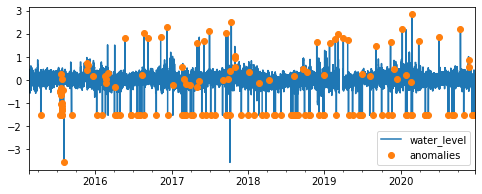

In [14]:
detected = data.to_frame()
detected["anomalies"] = data[std_anomalies.values]
detected.plot(style=['-', 'o'], figsize=(8,3))

# Hampel filter

The default threshold of the HampelDetector is 3, which means that a sample that deviates by more than three times of the rolling window's standard deviation is marked as an anomaly. **Increasing** the threshold marks **more** samples as anomalies, **decreasing** the threshold marks **fewer**.

In [15]:
detector = HampelDetector(window_size=20, threshold=3, use_numba=True)

In [16]:
anomalies = detector.detect(data)

<AxesSubplot:title={'center':'Anomalies detected: 292'}>

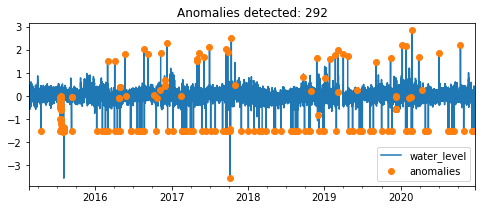

In [17]:
detected = data.to_frame()
detected["anomalies"] = data[anomalies]
detected.plot(style=['-', 'o'], figsize=(8,3), title=f'Anomalies detected: {sum(anomalies)}')

# AutoEncoder

In [18]:
from tsod.autoencoders import AutoEncoder
from tsod.features import lag_time_series

In [19]:
normal_data = data_clean["2015"].interpolate()  # fill gaps in chosen "normal" data period

In [20]:
max_lag = 100  # window_size
normal_data_lagged_features = lag_time_series(normal_data, lags=range(max_lag)).dropna() # TODO put in pipeline

In [21]:
detector = AutoEncoder(epochs=20) # hidden_neurons=[max_lag, 3, 3, max_lag]

In [22]:
detector.fit(normal_data_lagged_features)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [23]:
data_lagged_features = lag_time_series(data.interpolate(), lags=range(max_lag)).dropna()

In [24]:
anomalies = detector.detect(data_lagged_features) == 1

In [25]:
anomalies_time = data_lagged_features.index[anomalies]

<AxesSubplot:title={'center':'Anomalies detected: 26276'}>

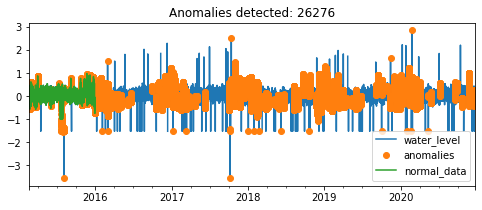

In [26]:
detected = data.to_frame()
detected["anomalies"] = data[anomalies_time]
detected["normal_data"] = normal_data
detected.plot(style=['-', 'o'], figsize=(8,3), title=f'Anomalies detected: {sum(anomalies)}')

In [27]:
# TODO extract reconstructed signal
# TODO save trained model